In [1]:
import pandas as pd
import geopandas as gpd
import folium
import os, shutil
from glob import glob
path = r'Folder_path'

In [4]:
from ipyleaflet import *

def handle_draw(self, action, geo_json):
    print(action)
    print(geo_json)

m = Map(center=[23, 71], zoom=8, name = 'Study Area', basemap = basemaps.OpenStreetMap.Mapnik, scroll_wheel_zoom = True)
tl = TileLayer(name = 'Satellite Tile View', url = 'http://www.google.cn/maps/vt?lyrs=s@189&gl=cn&x={x}&y={y}&z={z}')
m.add_layer(tl)
control = FullScreenControl(position='topleft')  
dc = DrawControl(marker={'shapeOptions': {'color': 'red'}},
                 rectangle={'shapeOptions': {'color': 'blue'}})
    
dc.on_draw(handle_draw)
m.add_control(control) 
# m.LatLngPopup()
m.add_control(dc)
m.add_control(LayersControl(position='topright'))
m

Map(center=[23, 71], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_tex…

In [3]:
bounds = gpd.read_file('/path/field1.geojson')#sentinel geojson/
bounds

geometry
0  POLYGON ((76.57341 17.76513, 76.57406 17.76513...
1  POLYGON ((77.51263 13.31639, 77.51339 13.31639...

In [5]:
tiles = gpd.read_file(r"/path/sentinel2_tiles_world.shp")

DriverError: Unable to open /home/archeron/Desktop/procurement/agri_python/plant_growth_tracking-master/sentinel2_tiles_world.shx or /home/archeron/Desktop/procurement/agri_python/plant_growth_tracking-master/sentinel2_tiles_world.SHX. Set SHAPE_RESTORE_SHX config option to YES to restore or create it.

In [5]:
tiles_intersection = tiles[tiles.intersects(bounds.geometry[0])]
tiles_intersection = tiles_intersection.reset_index(drop = True)

NameError: name 'tiles' is not defined

In [198]:
import numpy as np
xy = np.asarray(bounds.centroid[0].xy).squeeze()
center = list(xy[::-1])
zoom = 6
m = folium.Map(location=center, zoom_start=zoom, control_scale=True)
m.add_child(folium.GeoJson(bounds.__geo_interface__, name='Area of Study', 
                            style_function=lambda x: {'color': 'red', 'alpha': 0}))
# m.add_child(folium.GeoJson(bounds1.__geo_interface__, name='Area of Study', 
#                            style_function=lambda x: {'color': 'green', 'alpha': 0}))

g = folium.GeoJson(tiles_intersection.geometry.__geo_interface__, name = 'Sentinel-2 Tiles')
g.add_to(m)

folium.LayerControl().add_to(m)
m.save('tiles.html')
m

In [199]:
# connect to the API
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
from datetime import date

api = SentinelAPI('user_name', 'password', 'https://scihub.copernicus.eu/dhus')

# download single scene by known product id
#api.download(<product_id>)

# search by polygon, time, and SciHub query keywords##geojson_to_wkt(read_geojson('chandhan.geojson'))
footprint = geojson_to_wkt(read_geojson('path/field1.geojson'))
products = api.query(footprint,
                     date=('20190201', '20200101'),
                     platformname='Sentinel-2')

# download all results from the search
#a=api.download_all(products)

# convert to Pandas DataFrame
#products_df = api.to_dataframe(products)

# GeoJSON FeatureCollection containing footprints and metadata of the scenes
#api.to_geojson(products)

# GeoPandas GeoDataFrame with the metadata of the scenes and the footprints as geometries
data=api.to_geodataframe(products)

# Get basic information about the product: its title, file size, MD5 sum, date, footprint and
# its download url
#api.get_product_odata(<product_id>)

# Get the product's full metadata available on the server
#api.get_product_odata(<product_id>, full=True)

Querying products: 100%|██████████| 132/132 [00:00<00:00, 236.37 products/s]
/home/divya/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [200]:
data = data.reset_index(drop = True)
data.columns

Index(['title', 'link', 'link_alternative', 'link_icon', 'summary',
       'beginposition', 'endposition', 'ingestiondate', 'orbitnumber',
       'relativeorbitnumber', 'cloudcoverpercentage',
       'highprobacloudspercentage', 'mediumprobacloudspercentage',
       'notvegetatedpercentage', 'snowicepercentage', 'unclassifiedpercentage',
       'vegetationpercentage', 'waterpercentage', 'format',
       'instrumentshortname', 'instrumentname', 's2datatakeid',
       'platformidentifier', 'orbitdirection', 'platformserialidentifier',
       'processingbaseline', 'processinglevel', 'producttype', 'platformname',
       'size', 'filename', 'level1cpdiidentifier', 'identifier', 'uuid',
       'datatakesensingstart', 'sensoroperationalmode', 'tileid',
       'hv_order_tileid', 'granuleidentifier', 'datastripidentifier',
       'geometry'],
      dtype='object')

In [201]:
df = data[data.contains(bounds.geometry[0])]
df = df.reset_index(drop = True)
type(df)

geopandas.geodataframe.GeoDataFrame

In [211]:
#ndvi map from raster in python
def cal_month_list(starting_month, starting_year):
    year_month_list = []
    for i in range(int(starting_month),int(starting_month)+10):  
        if(i<=12):
            month_val = "-"  + str(i).zfill(2)              
            year_month_list.append(starting_year + month_val)        
        else:            
            month_val = '-0'+str(i-12)           
            year_month_list.append(str(int(starting_year)+1) + month_val) 
    return year_month_list

starting_month = '2'
starting_year = '2019'

year_month_list = cal_month_list(starting_month, starting_year)
print('tear month list:', year_month_list)
#getting starting date and query_end_date using year_month_list[3]
query_start_date = (starting_year + starting_month.zfill(2) + '01')
query_end_date = year_month_list[3][0:4]+year_month_list[3][5:7]+"01"
#discarding 3rd row of year_month_list
year_month_list = year_month_list
#Querying products using sentinel api for given area(geojson)
products_df = df
# finding unique tiles in product dataframe
tile_id = list(products_df.title.str.slice(39,44))
tile_list = list(set(tile_id))
no_of_tiles = len(tile_list)
no_of_months = len(year_month_list)
print(no_of_months)
# creating product array of size no_of_tiles*no_of_month to store title of required products that will be used in downloading 
best_products_tiles = np.empty([no_of_tiles,no_of_months], dtype=object)
print(best_products_tiles)
# fiiling product array with best cloud cover tile for respective tile and month
for tile_index in range(len(tile_list)):
    dataframe_tile_id = products_df[(products_df.title.str.contains(tile_list[tile_index]))]
    for year_month_index in range(len(year_month_list)):
        dataframe  = dataframe_tile_id[(dataframe_tile_id.summary.str.contains(year_month_list[year_month_index]))]
        best_data = dataframe.sort_values('cloudcoverpercentage').iloc[0]
        best_products_tiles[tile_index][year_month_index] = best_data['title']
del products_df

tear month list: ['2019-02', '2019-03', '2019-04', '2019-05', '2019-06', '2019-07', '2019-08', '2019-09', '2019-10', '2019-11']
10
[[None None None None None None None None None None]]


In [212]:
best_products_tiles

array([['S2A_MSIL1C_20190226T051751_N0207_R062_T43QFV_20190226T094956',
        'S2A_MSIL1C_20190328T051651_N0207_R062_T43QFV_20190328T103821',
        'S2B_MSIL1C_20190422T051659_N0207_R062_T43QFV_20190422T090414',
        'S2A_MSIL1C_20190517T051651_N0207_R062_T43QFV_20190517T081525',
        'S2B_MSIL2A_20190611T051659_N0212_R062_T43QFV_20190611T095322',
        'S2A_MSIL1C_20190716T051701_N0208_R062_T43QFV_20190716T081440',
        'S2B_MSIL1C_20190830T051659_N0208_R062_T43QFV_20190830T090836',
        'S2B_MSIL1C_20190929T051649_N0208_R062_T43QFV_20190929T090912',
        'S2B_MSIL1C_20191029T051929_N0208_R062_T43QFV_20191029T090522',
        'S2A_MSIL1C_20191123T052131_N0208_R062_T43QFV_20191123T071422']],
      dtype=object)

In [213]:
#import required libraries
import rasterio
from rasterio import plot
import matplotlib.pyplot as plt
from skimage.transform import rescale, resize
import pandas as pd
from flask import Flask, render_template, url_for, redirect, request, jsonify, Response 
import numpy as np
#from sentinelhub import AwsTile
import os
import geopandas as gpd
import json
import rasterio
from rasterio import MemoryFile
import matplotlib.pyplot as plt
from rasterio.merge import merge
import datetime
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
from rasterio.mask import mask
from shapely.geometry import box
from fiona.crs import from_epsg
import boto3
from rasterio.warp import calculate_default_transform
import folium
import time
import imageio
%matplotlib inline
# path = r'C:\Users\parag\Desktop\python\sentinel geojson\data'

In [214]:
ACCESS_KEY = 'AWS_ACCESS_KEY'
SECRET_KEY = 'AWS_SECRET_KEY'

#s3_client = boto3.client('s3','us-east-1', aws_access_key_id = ACCESS_KEY, aws_secret_access_key = SECRET_KEY)
s3_client_upload = boto3.client('s3','us-east-1', aws_access_key_id = ACCESS_KEY, 
                                aws_secret_access_key = SECRET_KEY)
s3_client = boto3.Session(aws_access_key_id=ACCESS_KEY,aws_secret_access_key=SECRET_KEY).client('s3')


In [216]:
import geopandas
import matplotlib.pyplot as plt
import rasterio
import rasterio.plot
bands = ['B04','B08']
for i in range(0,best_products_tiles[0].shape[0]):
    product_tile = best_products_tiles[0][i]
    tile_name, time, aws_index = product_tile[39:44], product_tile[11:15]+'-'+product_tile[15:17]+'-'+product_tile[17:19], 0
    print(tile_name, time, aws_index)
    for band_index in range(len(bands)):
        
#         key = os.path.join('tiles', str(int(tile_name[:2])), tile_name[2], tile_name[3:], 
#         str(pd.to_datetime(time).date().year),
#         str(pd.to_datetime(time).date().month), 
#         str(pd.to_datetime(time).date().day), str(aws_index), bands[band_index])+'.jp2'
        
        key = 'tiles/'+ str(int(tile_name[:2]))+'/'+str(tile_name[2])+'/'+ str(tile_name[3:])+'/'+str(pd.to_datetime(time).date().year)+'/'+str(pd.to_datetime(time).date().month)+'/'+str(pd.to_datetime(time).date().day)+'/'+str(aws_index)+'/'+bands[band_index]+'.jp2'
        print(key)

#         s3_client = boto3.Session(aws_access_key_id=ACCESS_KEY,
#         aws_secret_access_key=SECRET_KEY).client('s3')
        res = s3_client.get_object(Bucket='sentinel-s2-l1c',
        Key=key, RequestPayer='requester')
        response_content = res['Body'].read()
        download_path =path + product_tile + bands[band_index] +".jp2"
        with open(download_path, 'wb') as file:
                         file.write(response_content)
                         file.close()

43QFV 2019-02-26 0
tiles/43/Q/FV/2019/2/26/0/B04.jp2
tiles/43/Q/FV/2019/2/26/0/B08.jp2
43QFV 2019-03-28 0
tiles/43/Q/FV/2019/3/28/0/B04.jp2
tiles/43/Q/FV/2019/3/28/0/B08.jp2
43QFV 2019-04-22 0
tiles/43/Q/FV/2019/4/22/0/B04.jp2
tiles/43/Q/FV/2019/4/22/0/B08.jp2
43QFV 2019-05-17 0
tiles/43/Q/FV/2019/5/17/0/B04.jp2
tiles/43/Q/FV/2019/5/17/0/B08.jp2
43QFV 2019-06-11 0
tiles/43/Q/FV/2019/6/11/0/B04.jp2
tiles/43/Q/FV/2019/6/11/0/B08.jp2
43QFV 2019-07-16 0
tiles/43/Q/FV/2019/7/16/0/B04.jp2
tiles/43/Q/FV/2019/7/16/0/B08.jp2
43QFV 2019-08-30 0
tiles/43/Q/FV/2019/8/30/0/B04.jp2
tiles/43/Q/FV/2019/8/30/0/B08.jp2
43QFV 2019-09-29 0
tiles/43/Q/FV/2019/9/29/0/B04.jp2
tiles/43/Q/FV/2019/9/29/0/B08.jp2
43QFV 2019-10-29 0
tiles/43/Q/FV/2019/10/29/0/B04.jp2
tiles/43/Q/FV/2019/10/29/0/B08.jp2
43QFV 2019-11-23 0
tiles/43/Q/FV/2019/11/23/0/B04.jp2
tiles/43/Q/FV/2019/11/23/0/B08.jp2


In [218]:
images = []

for file in os.listdir(path):
    if file.startswith('S'):
        print(file)
        with rasterio.open(path + file, driver='JP2OpenJPEG') as data:
                transform, width, height = calculate_default_transform(data.crs, 
                                'EPSG:4326', data.width, data.height, *data.bounds)
                memfile =  MemoryFile() #as memfile:
                data1 = memfile.open(driver='Gtiff',width=width, height=height,
                                count=1,crs='EPSG:4326',transform=transform,dtype='float32')
                reshaped_data = np.array([data.read(1)])     
                data1.write(reshaped_data.astype('float32'))
                images.append(data1)
            

S2B_MSIL1C_20190830T051659_N0208_R062_T43QFV_20190830T090836B08.jp2
S2A_MSIL1C_20190328T051651_N0207_R062_T43QFV_20190328T103821B04.jp2
S2B_MSIL1C_20191029T051929_N0208_R062_T43QFV_20191029T090522B08.jp2
S2B_MSIL1C_20190929T051649_N0208_R062_T43QFV_20190929T090912B08.jp2
S2A_MSIL1C_20191123T052131_N0208_R062_T43QFV_20191123T071422B04.jp2
S2A_MSIL1C_20190226T051751_N0207_R062_T43QFV_20190226T094956B08.jp2
S2A_MSIL1C_20190716T051701_N0208_R062_T43QFV_20190716T081440B04.jp2
S2B_MSIL1C_20191029T051929_N0208_R062_T43QFV_20191029T090522B04.jp2
S2A_MSIL1C_20191123T052131_N0208_R062_T43QFV_20191123T071422B08.jp2
S2B_MSIL1C_20190830T051659_N0208_R062_T43QFV_20190830T090836B04.jp2
S2B_MSIL1C_20190422T051659_N0207_R062_T43QFV_20190422T090414B08.jp2
S2A_MSIL1C_20190716T051701_N0208_R062_T43QFV_20190716T081440B08.jp2
S2A_MSIL1C_20190517T051651_N0207_R062_T43QFV_20190517T081525B08.jp2
S2B_MSIL2A_20190611T051659_N0212_R062_T43QFV_20190611T095322B04.jp2
S2B_MSIL2A_20190611T051659_N0212_R062_T43QFV_201

In [168]:
def generate_bbox(geo_json):
    bounds = gpd.read_file(geo_json)
    # minlat = bounds.bounds.minx[0]
    # maxlat = bounds.bounds.maxx[0]
    # minlong = bounds.bounds.miny[0]
    # maxlong = bounds.bounds.maxy[0]
    # bbox = box(minlat, minlong, maxlat, maxlong)
    return bounds.geometry

In [169]:
bbox = generate_bbox('path/field1.geojson')

In [170]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

In [171]:
--------------def getmasked(src_files_to_mosaic, bbox):
    mosaic, out_trans = merge(src_files_to_mosaic)
#     for file in src_files_to_mosaic:
#         file.close()
    #Writing mosaiic as a tif with meta data using source file 
    with MemoryFile() as memfile:
        with memfile.open(driver='Gtiff',width=mosaic.shape[2], height=mosaic.shape[1], count=1, crs=src_files_to_mosaic[0].crs, transform=out_trans, dtype='float32') as data:
            data.write(mosaic)
            del mosaic
            geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(4326))
            geo = geo.to_crs(crs=data.crs.data)
            coords = getFeatures(geo['geometry'])
            #mask the mosaiced file with bounding box
            out_img, out_transform = mask(data, coords, crop = True)
            memfile1 = MemoryFile() #as memfile1:
            data1 = memfile1.open(driver='Gtiff',width=out_img.shape[2], height=out_img.shape[1], count=1, crs=src_files_to_mosaic[0].crs, transform=out_transform, dtype='float32')# as data1:
            data1.write(out_img)
            return data1

In [ ]:
def cal_band_array(band1_arr, band2_arr):
    indice_arr = np.zeros(band1_arr.shape, dtype = band1_arr.dtype)
    for i in range(band1_arr.shape[0]):
        for j in range(band1_arr.shape[1]):
            if (band1_arr[i][j] + band2_arr[i][j] == 0.0):
                indice_arr[i][j] = 0.0
            else:
                indice_arr[i][j] = (band1_arr[i][j]-band2_arr[i][j])/(band1_arr[i][j]+band2_arr[i][j])
    return indice_arr

# feb vegitation

<open DatasetWriter name='/vsimem/1830602e-9bf8-4bbf-8e30-6389f80510cc.' mode='w+'>
<open DatasetWriter name='/vsimem/95e6c6d5-9c3c-4e69-be8f-0cb87cf7e75f.' mode='w+'>


/home/divya/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/divya/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


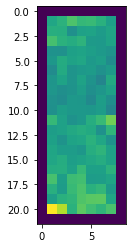

In [229]:
print(images[5])
print(images[-5])
b08_feb = getmasked( [images[5]], bbox)
b04_feb = getmasked([images[-5]], bbox)
ndvi_feb = cal_band_array(b08_feb.read(1), b04_feb.read(1))
plt.imshow(ndvi_feb)

# march vegitation

/home/divya/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/divya/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


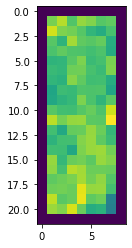

In [220]:
b08_march = getmasked( [images[-2]], bbox)
b04_march = getmasked([images[1]], bbox)
ndvi_march = cal_band_array(b08_march.read(1), b04_march.read(1))
plt.imshow(ndvi_march)

# april vegitation

In [221]:
b08_april = getmasked( [images[10]], bbox)
b04_april = getmasked([images[-3]], bbox)
ndvi_april = cal_band_array(b08_april.read(1), b04_april.read(1))
plt.imshow(ndvi_april)

/home/divya/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/divya/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


# may vegitation

In [222]:
b08_may = getmasked( [images[12]], bbox)
b04_may = getmasked([images[-1]], bbox)
ndvi_may = cal_band_array(b08_may.read(1), b04_may.read(1))
plt.imshow(ndvi_may)

/home/divya/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/divya/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


# june vegitation

/home/divya/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/divya/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


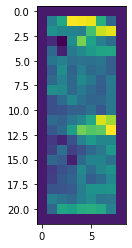

In [230]:
b08_june = getmasked( [images[14]], bbox)
b04_june = getmasked([images[13]], bbox)
ndvi_june = cal_band_array(b08_june.read(1), b04_june.read(1))
plt.imshow(ndvi_june)

# july vegitation

/home/divya/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/divya/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


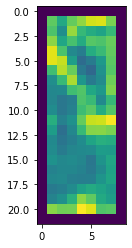

In [231]:
b08_july = getmasked( [images[11]], bbox)
b04_july = getmasked([images[6]], bbox)
ndvi_july = cal_band_array(b08_july.read(1), b04_july.read(1))
plt.imshow(ndvi_july)

# AUGUST VEGITATION

/home/divya/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/divya/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


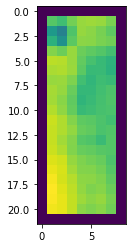

In [232]:
b08_aug = getmasked( [images[0]], bbox)
b04_aug = getmasked([images[9]], bbox)
ndvi_aug = cal_band_array(b08_aug.read(1), b04_aug.read(1))
plt.imshow(ndvi_aug)


# sept vegitation

/home/divya/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/divya/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


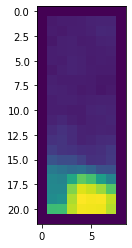

In [233]:
b08_sept = getmasked( [images[3]], bbox)
b04_sept = getmasked([images[-4]], bbox)
ndvi_sept = cal_band_array(b08_sept.read(1), b04_sept.read(1))
plt.imshow(ndvi_sept)

# oct vegitation

/home/divya/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/divya/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


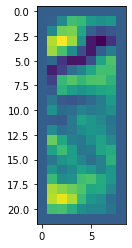

In [234]:
b08_oct = getmasked( [images[2]], bbox)
b04_oct = getmasked([images[7]], bbox)
ndvi_oct = cal_band_array(b08_oct.read(1), b04_oct.read(1))
plt.imshow(ndvi_oct)

# nov vegitation

/home/divya/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/divya/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


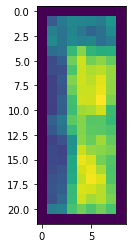

In [235]:
b08_nov = getmasked( [images[8]], bbox)
b04_nov = getmasked([images[4]], bbox)
ndvi_nov = cal_band_array(b08_nov.read(1), b04_nov.read(1))
plt.imshow(ndvi_nov  )

In [236]:
feb_avg_ndvi = np.average(ndvi_feb)
march_avg_ndvi = np.average(ndvi_march)
april_avg_ndvi = np.average(ndvi_april)
may_avg_ndvi = np.average(ndvi_may)
june_avg_ndvi = np.average(ndvi_june)
july_avg_ndvi = np.average(ndvi_july)
aug_avg_ndvi = np.average(ndvi_aug)
sept_avg_ndvi = np.average(ndvi_sept)
oct_avg_ndvi = np.average(ndvi_oct)
nov_avg_ndvi = np.average(ndvi_nov)

In [237]:
ndvi_sept.shape

(22, 9)

In [181]:
import numpy as np
print('aug avg: ', np.average(ndvi_aug))
print('sept avg: ',  np.average(ndvi_sept))
print('oct avg: ',  np.average(ndvi_oct))

aug avg:  0.4306456
sept avg:  0.12407404
oct avg:  0.025598006


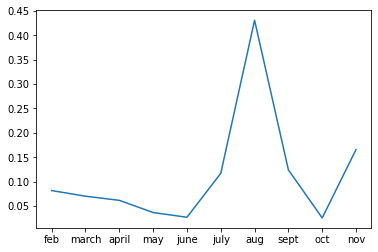

In [238]:
import matplotlib.pyplot as plt
x = ['feb', 'march','april','may','june','july','aug', 'sept', 'oct', 'nov']
y = [feb_avg_ndvi, march_avg_ndvi, april_avg_ndvi, may_avg_ndvi, june_avg_ndvi, july_avg_ndvi, aug_avg_ndvi, sept_avg_ndvi, oct_avg_ndvi, nov_avg_ndvi]
plt.plot(x,y)
plt.show()